# Reducción de Dimensionalidad

Los algoritmos de Machine Learning que hemos estudiado buscan extraer *insights* de un conjunto de datos ya sea de manera supervisada o no-supervisada. Dichos datos son representaciones de ciertos fenomenos, cuyo "tamaño" se denomina **dimensionalidad**. A mayor complejidad de un fenomeno y detalle de la descripción mayor será la dimensionalidad de nuestra representación. 

Existe un balance importante entre el performance de un modelo y el detalle con el que se lo describe. El desempeño de un buen modelo puede decaer significativamente cuando la dimensionalidad de los datos ocupados se incrementa. Esto se debe a varias razones:

- Requieren mas datos para ser entrenados
- Los datasets requieren mayor espacio en memoria
- El entrenamiento se vuelve mas lento
- Datasets con grandes cantidades de datos tiene muchos campos correlacionados entre sí. Un modelo robusto tiene sus features independientes una de la otra

Estos problemas, entre otros, se conocen como **la maldición de la dimensionalidad** (también conocido como *curse of dimensionality*). Se puede disminuir el el tamaño de la representación usando Feature Engineering, en particular:

- **Feature Selection**: Eliminar ciertas Features del conjunto de datos. Se puede hacer usando conocimiento específico, análisis de correlación, eliminacion recursiva de features (RFE por sus siglas en ingles) o un método backward, etc.

- **Feature Extraction**: Creación de variables sintéticas que reflejen el comportamiento de los datos a pesar de ser muchas menos que las originales. Algunos ejemplos son Análisis de componentes principales (PCA) y Analisis Factorial (FA), que son los que veremos hoy.
 

## Análisis de Componentes Principales

Primero importaremos las librerias para todo lo que usaremos

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Config:
plt.style.use("seaborn-whitegrid")
%config InlineBackend.figure_format = "svg"

Usaremos los datos USArrests ya que aunque solo tiene 4 campos, y PCA se suele utilizar cuando tenemos mucha más información, podremos ir visualizando paso a paso el procedimiento. Los campos son: Murder, Assault, UrbanPop y Rape.

En las filas tenemos los distintos 50 estados de USA

In [2]:
USArrests = sm.datasets.get_rdataset("USArrests", "datasets")
datos = USArrests.data
datos.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Veamos rápidamente información de la data:

In [3]:
print("Información del dataset:\n")
datos.info()
print("\nDescripción del dataset:")
datos.describe()

Información del dataset:

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB

Descripción del dataset:


,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


Notemos que la varianza y la media de Assault es muy superior al resto. Por lo tanto explicaría mayor variabilidad de los datos y el análisis de PCA no tendría sentido. Es por esto, que lo primero que debemos hacer es estandarizar los datos, para que toda la información esté a la misma escala. 

Como primero transformaremos los datos y luego los pondremos al cálculo del modelo PCA, lo mejor es realizar un pipeline, tal y como lo hemos visto en clases anteriores

In [4]:
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(datos)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

Como el `.fit` está aplicado al objeto pca_pipe, podemos extraer el modelo llamando a dicho objeto y rescatando directamente el pca:

In [5]:
modelo_pca = pca_pipe.named_steps['pca']

Analizaremos las distintas características del modelo para ir entendiendo las salidas. Primero veremos los `eigenvector` que podemos extraer con `.components_`

In [6]:
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = datos.columns,
    index   = [f"PC{num + 1}" for num in range(datos.shape[1])]
)

,Murder,Assault,UrbanPop,Rape
PC1,0.535899,0.583184,0.278191,0.543432
PC2,0.418181,0.187986,-0.872806,-0.167319
PC3,-0.341233,-0.268148,-0.378016,0.817778
PC4,0.649228,-0.743407,0.133878,0.089024


Así podremos observar cuanta variabilidad explica cada uno de los 4 Componentes Principales, para cada uno de los atributos que tenemos. Por ejemplo el primer componente principal, obtiene su variabilidad principalmente de las variables Murder, Assault y Rape. Por lo que toma buena información de los delitos.

De manera análoga, en la segunda componente, vemos que UrbanPop es la que tiene mayor peso (pues vemos el valor absoluto obviando el signo), la que corresponde al nivel de urbanización.

Ahora con las PCA creadas, podemos saber cuanta variabilidad de los datos explica cada una de ellas:

In [7]:
modelo_pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

La primera PCA puede xplicar el 62% de la variabilidad de los datos, y la segunda el siguiente 24%, luego la tercera y cuarta el 8% y 4% aproximadamente. Es decir, que con las 2 primeras CP, podemos explicar un 86% de los datos aproximadamente.

Hay personas que prefieren observar esto gráficamente:

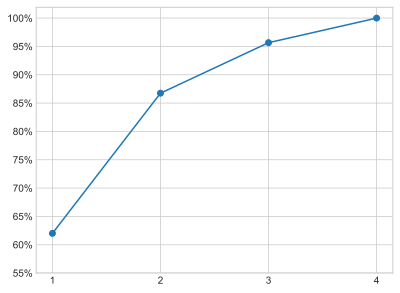

In [8]:
plt.plot(
    range(1, len(modelo_pca.components_) + 1),
    np.cumsum(modelo_pca.explained_variance_ratio_),
    marker = "o"
)
plt.xticks(
    ticks = np.arange(datos.shape[1]) + 1,
)
plt.yticks(
    ticks  = np.linspace(0.55, 1, 10),
    labels = [f"{val:0.0%}" for val in np.linspace(0.55, 1, 10)]
);

Finalmente lo que necesitamos es crear un nuevo set de datos, donde los registros sigan siendo los 50 estados, pero ahora los campos sean nuestras PCA, esto lo logramos con `transform()`

In [9]:
datos_proyectados = pca_pipe.transform(datos)

In [10]:
proyecciones = pd.DataFrame(
    datos_proyectados,
    columns = [f"PC{num + 1}" for num in range(datos.shape[1])],
    index   = datos.index
)
proyecciones.head()

,PC1,PC2,PC3,PC4
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996


Finalmente, como sabemos que para un modelo tenemos el 86% de la data explicada con las primeras 2 PCA, solo deberiamos usar esas dos:

In [11]:
df_para_modelo = proyecciones.iloc[:,0:2]
df_para_modelo.head(3)

,PC1,PC2
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957


### Optimización de Número de Componentes para mejorar Métricas

Un uso bastante común del PCA, es incorporarlo como etapa de preprocesamiento de modelos supervisados. Lo importante es seleccionar la cantidad de componente que maximicen (o minimicen según el caso) la performance del modelo supervisado.

En el siguiente ejemplo, veremos como minimizar el MAE (*Mean Absolute Error* por sus siglas en inglés) de la predicción del valor ajustado del oro en cierta jornada.

In [12]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression

In [13]:
oro = pd.read_csv("https://raw.githubusercontent.com/DiegoHoliwis/Diplomado_DS/main/Bases_Python/valor-oro.csv")
X = oro.drop(columns="Adj Close")
y = oro["Adj Close"]
print("Cantidad de datos      :", X.shape[0])
print("Cantidad de predictores:", X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022, test_size=0.4)
kfold = KFold(n_splits=5, shuffle=True, random_state=2022)

Cantidad de datos      : 1718
Cantidad de predictores: 74


Programemos el pipeline a optimizar, este debe considerar estandarización de los datos, ajuste de componentes principales y un modelo de regresión lineal (por ejemplo).

In [14]:
pipeline = make_pipeline(
    StandardScaler(),
    PCA(random_state=2022),
    LinearRegression()
)

Ahora creemos la grilla de hiperparámetros a optimizar, en este caso nos interesan valores respecto a la cantidad de componentes (`n_components`) del algoritmo `PCA`.

In [15]:
hiperparametros = {
    "pca__n_components": np.arange(2, oro.shape[1] - 1) + 1
}
print("Hiperpárametros a probar:")
print(hiperparametros)

Hiperpárametros a probar:
{'pca__n_components': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74])}


Y ajustemos los modelos:

In [16]:
modelos = GridSearchCV(
    estimator  = pipeline,
    param_grid = hiperparametros,
    cv         = kfold,
    scoring    = "neg_mean_absolute_error",
    n_jobs     = -1,
    verbose    = 1
)
modelos.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=2022, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA(random_state=2022)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'pca__n_components': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74])},
             scoring='neg_mean_absolute_error', verbose=1)

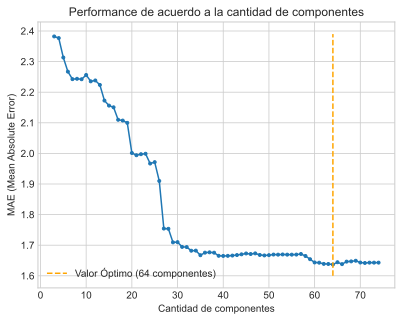

In [17]:
plt.plot(
    hiperparametros["pca__n_components"],
    -modelos.cv_results_["mean_test_score"],
    marker="."
)
plt.vlines(
    x          = 64,
    ymin       = 1.6,
    ymax       = 2.39,
    linestyles = "--",
    colors     = "orange",
    label      = "Valor Óptimo (64 componentes)"
)
plt.title("Performance de acuerdo a la cantidad de componentes")
plt.xlabel("Cantidad de componentes")
plt.ylabel("MAE (Mean Absolute Error)")
plt.legend(loc="lower left");

## Análisis Factorial

Anteriormente pudimos reducir la dimensionalidad pero de variables continuas. Nos vimos forzados además de estandarizar los datos para poder proyectar las dimensiones de manera correcta. 

Otro caso de uso en que podríamos requerir de reducción de dimensionalidad es en Análisis Factorial, pero la diferencia es que este no busca crear componentes que máximicen la varianza explicada, sino que busca crear un conjunto de variables menor que el original, que exprese lo que es común a las variables originales.

En concreto en este ejemplo, trabajaremos con psicométrica de factores:

* Para esta actividad utilizaremos un subconjunto de 25 items de la International Personality Item Pool, aplicados a 2800 individuos. 


* El objetivo de esta información es desarrollar perfiles de personalidad en base a una serie de oraciones asociadas a las características Amabilidad, Escrupolisidad, Extroversión, Neuroticismo, Apertura. 


* Los individuos deben responder qué tan adecuada es la oración respecto a su personalidad en base a una escala del 1 al 6:

    - 1: No me representa para nada.
    - 2: No me representa.
    - 3: Algunas cosas no me representan.
    - 4: Algunas cosas me representan.
    - 5: Me representa.
    - 6: Me representa completamente.


* Las 25 preguntas son:
    * `A1`  Soy indiferente a los sentimientos de otros.
    * `A2` Me preocupo del bienestar de otros. 
    * `A3` Sé cómo confortar a otros.
    * `A4` Me agradan los niños. 
    * `A5` Hago sentir tranquila a la gente. 
    * `C1` Soy exacto en mi trabajo.
    * `C2` Sigo con mis tareas hasta que todo esté perfecto.
    * `C3` Hago cosas siguiendo un plan.
    * `C4` Hago cosas con el mínimo esfuerzo.
    * `C5` Pierdo mi tiempo. 
    * `E1` No hablo mucho con las personas.
    * `E2` Me es dificil acercarme a otros.
    * `E3` Sé cómo cautivar gente.
    * `E4` Hago amigos de forma fácil. 
    * `E5` Puedo tomar el cargo de las cosas. 
    * `N1` Me enojo con facilidad.
    * `N2` Me irrito con facilidad.
    * `N3` Tengo cambios de humor frecuentes.
    * `N4` Usualmente me siento melancólico. 
    * `N5` Entro en pánico con facilidad. 
    * `O1` Estoy lleno de ideas.
    * `O2` Evito leer material difícil.
    * `O3` Tiendo a llevar la conversación a niveles más altos.
    * `O4` Dedico tiempo a la reflexión de cosas. 
    * `O5` No profundizaré sobre una materia específica.


* Implementaremos un modelo de extracción factorial para identificar los principales perfiles psicológicos.

In [18]:
# Importaremos las librerias adicionales a este caso
import scipy.stats as stats
import seaborn as sns
import missingno as msngo
# !pip install factor_analyzer
import factor_analyzer as factor

In [19]:
df = pd.read_csv("https://raw.githubusercontent.com/DiegoHoliwis/Diplomado_DS/main/Bases_Python/bfi.csv")
df.head()

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N1,N2,N3,N4,N5,O1,O2,O3,O4,O5
0,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,...,3.0,4.0,2.0,2.0,3.0,3.0,6,3.0,4.0,3.0
1,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,4.0,...,3.0,3.0,3.0,5.0,5.0,4.0,2,4.0,3.0,3.0
2,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,5.0,...,4.0,5.0,4.0,2.0,3.0,4.0,2,5.0,5.0,2.0
3,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,5.0,...,2.0,5.0,2.0,4.0,1.0,3.0,3,4.0,3.0,5.0
4,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,2.0,...,2.0,3.0,4.0,4.0,3.0,3.0,3,4.0,3.0,3.0


Top 10 de Datos Faltantes (%):


N4    1.285714
N5    1.035714
O3    1.000000
A2    0.964286
A3    0.928571
C4    0.928571
E3    0.892857
C2    0.857143
E1    0.821429
O1    0.785714
dtype: float64

<Figure size 400x400 with 0 Axes>

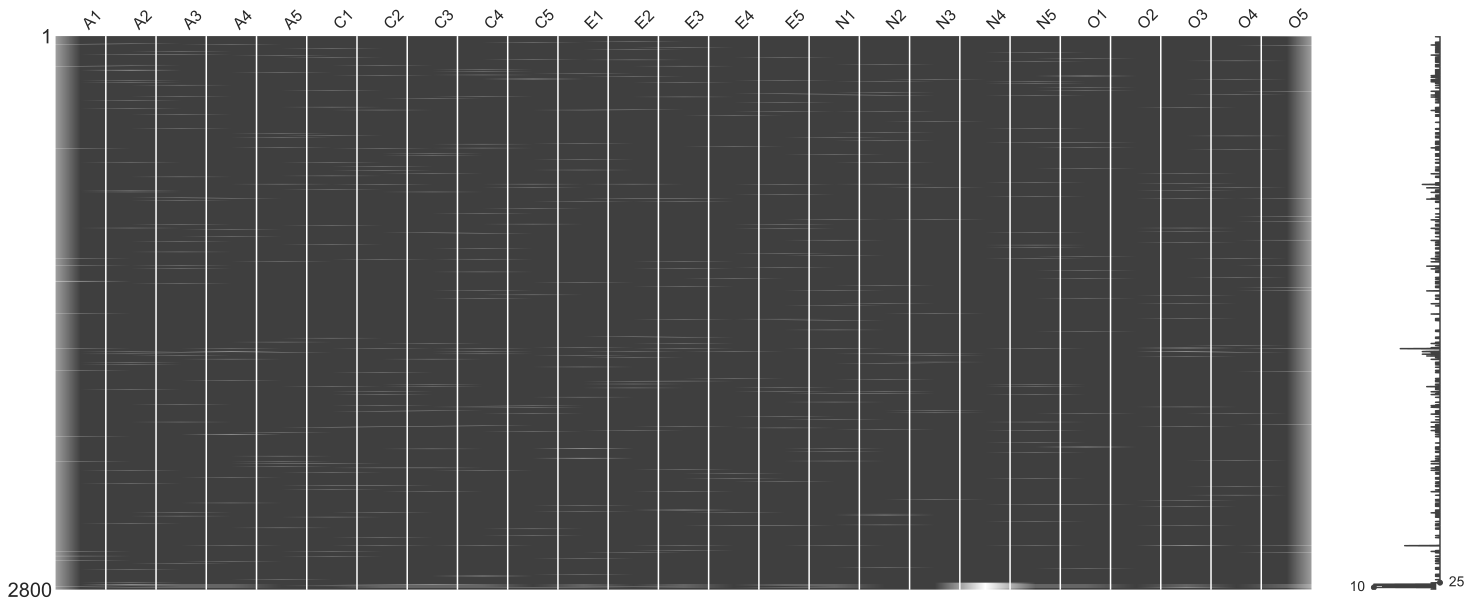

In [20]:
plt.figure(figsize=(4,4));
msngo.matrix(df.sort_values("N4"));
datos_faltantes = df.isna().mean()
print("Top 10 de Datos Faltantes (%):")
datos_faltantes.sort_values(ascending=False).head(10) * 100

La variable con mayor casos perdidos es education con un 7.9%, sin embargo esta no entra al análisis factorial, pues solo unificaremos las preguntas del set.

Por otro lado las variables con mayor porcentaje de datos perdidos son: N4 (1.2%), N5 (1.03%), O3 (1%) y A2 (0.9%).

Eliminaremos todos los datos perdidos para poder utilizar las librerias de python. Pero un buen preprocesamiento debería ser capaz de analizar que hacer con esta información.

In [21]:
df.dropna(inplace=True)

Ahora haremos lo siguiente
* Reportaremos las medias para cada uno de las preguntas de la batería con un dotplot.
* Generemos una matriz de correlaciones con este nuevo objeto y lo visualizaremos con heatmap.

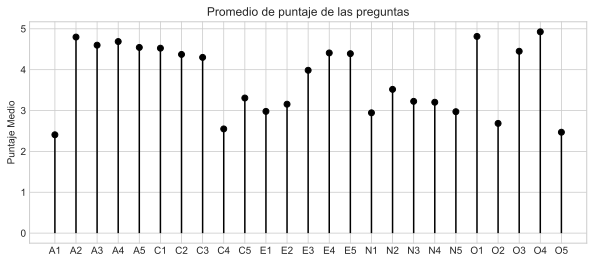

In [22]:
medias = df.agg("mean")

fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(
    x     = medias.index,
    y     = medias,
    color = "black"
)
ax.vlines(
    x     = medias.index,
    ymin  = 0,
    ymax  = medias,
    color = "black"
)
ax.set_ylabel("Puntaje Medio")
ax.set_title("Promedio de puntaje de las preguntas");

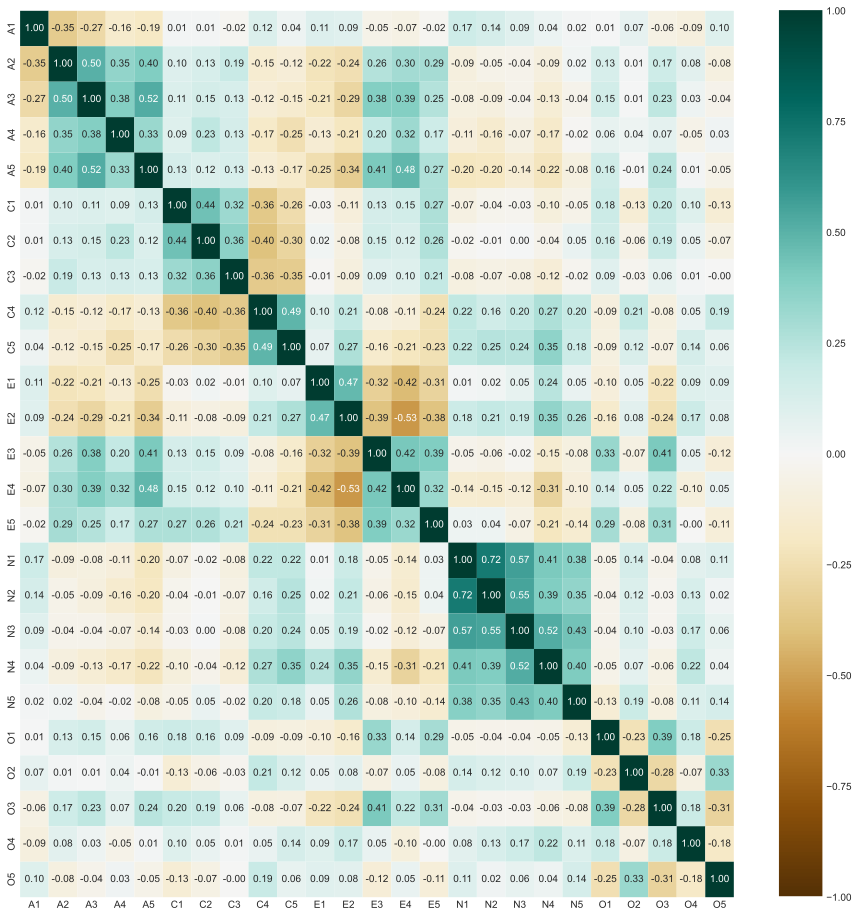

In [23]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(
    data  = corr,
    cmap  = "BrBG",
    vmin  = -1,
    vmax  = 1,
    annot = True,
    fmt   = ".2f",
    ax    = ax
);

Se evidencia una correlación baja en la mayoría de las variables mezcladas, pero se evidencia cierta correlación entre la misma cateogría de variables. Por ejemplo las preguntas "N" que estan correlacionadas entre si (llamemosle "preguntas furia") y las preguntas A (llamemosle preguntas "condescendiente"), también presentan una relación entre sí. Pero las preguntas "N" con las "A" no presentan altos niveles de correlación

Ya con nuestro preprocesamiento listo procederemos a la construcción de nuestros análisis factoriales.

Antes de iniciar la extracción de factores, debemos inspeccionar los supuestos de la ideonidad de la batería de preguntas para realizar un análisis factorial mediante la prueba de esferacidad de Barlett y Kaiser-Meyer-Olkin. 

El test de Barlett dice que:

$$H_0: \text{La matriz de correlaciones entre las variables es una matriz identidad}$$
$$H_a: \text{La matriz de correlaciones entre las variables es distinta a una identidad}$$


In [24]:
resultados = factor.calculate_bartlett_sphericity(df)
print("Estadístico:", resultados[0])
print("Valor p:", resultados[1])
#Nota: Si existe algun NA en la matriz, esta función no sacará resultados

Estadístico: 18146.065577235386
Valor p: 0.0


Como su estadístico es muy alto, su valor-p es prácticamente 0. Con ello rechazamos la hipótesis nula en favor de la alternativa. Esto significa que la matriz de correlacion es distinta de la identidad, y con ello tiene sentido buscar relación entre las variables

De manera adicional a la prueba de Bartlett, podemos medir si las correlaciones parciales
dentro de la matriz son cercanas a 0. De ser este el caso, la prueba sugiere la existencia de
por lo menos un factor latente dentro de la batería de preguntas.
Se puede implementar mediante el método calculate_kmo de la librería factor_analyzer.
El método devuelve el puntaje KMO para cada ítem dentro de la batería, así como un puntaje
global para todos los items.
Se sugiere que para seguir con el análisis factorial, el KMO debe presentar valores
superiores a .7

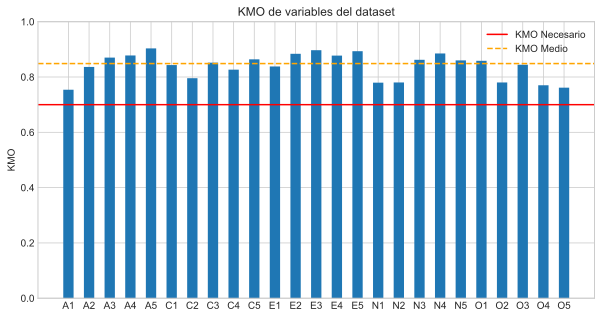

In [25]:
resultados = factor.calculate_kmo(df)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(
    x      = df.columns,
    height = resultados[0],
    width  = 0.5
)
ax.axhline(
    y         = 0.7,
    color     = "red",
    label="KMO Necesario"
)
ax.axhline(
    y         = resultados[1],
    linestyle = "--",
    color     = "orange",
    label     = "KMO Medio"
)
ax.set_ylim(0, 1)
ax.set_ylabel("KMO")
ax.set_title("KMO de variables del dataset")
ax.legend();

Todas las variables tienen un KMO mayor a 0.7 y de manera global es de 0.84, por lo que cumple esta condición.

Nota: Ante el caso en que encontremos puntajes bajos, la estructura a estimar se puede mejorar al
eliminar los ítems con cargas KMO inferiores al puntaje de corte.
La eliminación de estos ítems permite liberar la matriz de elementos inestables que
dificulten la identificación de los factores a extraer.

Ahora veremos cuantos factores deberíamos utilizar, ajustando el modelo con la cantidad máxima de factores posible, o sea la cantidad que la de columnas en los datos menos uno.

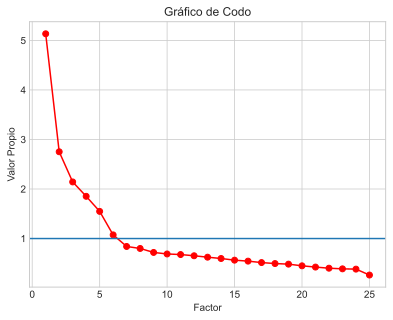

In [26]:
# Generamos una nueva instancia en el objeto factorize
factorize = factor.FactorAnalyzer(n_factors=df.shape[1] - 1, rotation="varimax")
# # Implementamos el análisis
factorize.fit(df)
# extraemos los eigenvalues
factor_screeplot = factorize.get_eigenvalues()[0]
# graficamos los eigenvalues contra la cantidad de dimensiones estimables
plt.plot(
    np.arange(factor_screeplot.shape[0]) + 1, 
    factor_screeplot,
    marker = 'o',
    color  = 'red'
)
plt.xlabel('Factor')
plt.ylabel('Valor Propio')
# visualizamos el criterio de corte
plt.axhline(1)
plt.title("Gráfico de Codo");

In [27]:
print("Valores propios asociados a cada factor:")
factor_screeplot

Valores propios asociados a cada factor:


array([5.13431118, 2.75188667, 2.14270195, 1.85232761, 1.54816285,
       1.07358247, 0.83953893, 0.79920618, 0.71898919, 0.68808879,
       0.67637336, 0.65179984, 0.62325295, 0.59656284, 0.56309083,
       0.54330533, 0.51451752, 0.49450315, 0.48263952, 0.448921  ,
       0.42336611, 0.40067145, 0.38780448, 0.38185679, 0.26253902])

A modo de guía: Un factor con valor propio de exactamente 1 significa que ese factor
explica una parte de la varianza igual a la de una variable, de forma análoga, un factor con
valor propio mayor/menor a 1 explica una varianza total mayor/menor a la de una sola
variable.
La convención indica que se deben preservar todos los factores con eigenvalues mayores a 1. De esta forma maximizamos la cantidad de varianza explicada por la matriz. Los
resultados indican que hay 2 dimensiones sustanciales.

En este caso los primeros 6 tienen un valor mayor a 1, pero el sexto factor tiene un valor de 1.07, por lo que por razones expositivas lo sacaremos para simplificar los factores latentes

In [28]:
factorize2 = factor.FactorAnalyzer(n_factors=5, rotation='varimax')
factorize2.fit(df)

FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [38]:
# Extraemos los factores latentes
factor_loadings = factorize2.loadings_
# Pondremos todo en un df para una visualización más facil
loadings_df = pd.DataFrame(
    data    = factor_loadings,
    columns = [f"Factor {num + 1}" for num in range(5)],
    index   = df.columns
)

# Destacaremos todas las cargas mayores a 0.4
loadings_df.style.highlight_between(left=0.4, right=loadings_df.to_numpy().max(), color="lightgreen")

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
A1,0.111126,0.040465,0.022798,-0.428166,-0.077931
A2,0.029588,0.213716,0.139037,0.626946,0.062139
A3,0.009357,0.317848,0.109331,0.650743,0.056196
A4,-0.066476,0.204566,0.230584,0.435624,-0.112700
A5,-0.122113,0.393034,0.087869,0.537087,0.066708
C1,0.010416,0.070184,0.545824,0.038878,0.209584
C2,0.089574,0.033270,0.648731,0.102782,0.115434
C3,-0.030855,0.023907,0.557036,0.111578,-0.005183
C4,0.240410,-0.064984,-0.633806,-0.037498,-0.107535
C5,0.290318,-0.176395,-0.562467,-0.047525,0.036822


Claramente los factores están muy asociados a las preguntas: simplemente se podria llamar al Factor1: preguntas N, al Factor2, preguntas E, etc. Unos nombres más interesantes podrían ser:

    * Factor 1: Emociones_ira_pena
    * Factor 2: Capacidad_social
    * Factor 3: Pulcritud
    * Factor 4: Condescendencia
    * Factor 5: Creatividad_y_Debate

In [39]:
factorize2.get_factor_variance() # explicación de la varianza

(array([2.70963262, 2.47308983, 2.04110564, 1.844498  , 1.52215297]),
 array([0.1083853 , 0.09892359, 0.08164423, 0.07377992, 0.06088612]),
 array([0.1083853 , 0.2073089 , 0.28895312, 0.36273304, 0.42361916]))

Analicemos lo que tenemos hasta ahora:

La data tiene tiene 2236 filas y 25 columnas, que sería el set de datos original con sus variables que serán factorizadas.

Ahora nos interesa obtener el *factor score* para cada observación en cada uno de los factores creados, esto se obtiene usando el método `transform`, que entrega un array con los valores mencionados. 

In [31]:
df_factores = factorize2.transform(df)

In [32]:
df_factores = pd.DataFrame(df_factores)
df_factores.columns = ['Emociones_ira_pena', 'Capacidad_social', 'Pulcritud', 'Condescendencia', 'Creatividad_y_Debate']
df_factores.head()

,Emociones_ira_pena,Capacidad_social,Pulcritud,Condescendencia,Creatividad_y_Debate
0,-0.439830,0.103897,-1.216713,-0.696215,-1.519449
1,0.084369,0.559311,-0.601521,-0.189341,-0.248384
2,0.520534,0.318235,0.025646,-0.751136,0.204503
3,-0.197064,0.057696,-1.019263,0.064286,-1.029492
4,-0.329835,0.408754,-0.058843,-0.820454,-0.691042


In [33]:
display(df_factores.shape)

(2436, 5)

# Ejercicios

La base de datos *House_price.csv* contiene información de casas. La idea es obtener un modelo que permita predecir el valor de venta de una casa. Las variables son las siguientes:

- LotFrontage: Pies lineales de calle conectados a la propiedad
- LotArea: Tamaño del lote en pies cuadrados
- MasVnrArea: Área de revestimiento de mampostería en pies cuadrados
- BsmtFinSF1: Pies cuadrados del sótano terminados tipo 1
- BsmtFinSF2: Pies cuadrados con del sótano acabados tipo 2
- BsmtUnfSF: Pies cuadrados sin terminar de área del sótano
- TotalBsmtSF: Total de pies cuadrados de área del sótano
- 1stFlrSF: Pies cuadrados del primer piso
- 2ndFlrSF: Pies cuadrados del segundo piso
- LowQualFinSF: Pies cuadrados con acabado de baja calidad (todos los pisos)
- GrLivArea: Pies cuadrados de área habitable sobre el nivel (suelo)
- GarageArea: Tamaño del garaje en pies cuadrados
- WoodDeckSF: Área de la plataforma de madera en pies cuadrados
- OpenPorchSF: Área del porche abierto en pies cuadrados
- EnclosedPorch: Área del porche cerrado en pies cuadrados
- 3SsnPorch: área de porche de tres estaciones en pies cuadrados
- ScreenPorch: Área del porche de la pantalla en pies cuadrados
- PoolArea: Área de la piscina en pies cuadrados
- MiscVal: Valor de la función miscelánea


- SalePrice: el precio de venta de la propiedad en dólares. Esta es la variable objetivo que se quiere modelar.

### a) Cargue la base de datos, ¿hay alguna columna que no sea útil para el análisis?. Revise si existen casos faltantes en la base de datos, según la descripción de las variables, ¿qué podría significar un NA? Tome decisiones de qué hacer si existen casos faltantes. Si desea imputar los valores nulos de alguna variable por un valor puede utilizar data["columna"].fillna('valor', inplace = True).

In [34]:
# Responda aquí:
import pandas as pd
data = pd.read_csv(
    filepath_or_buffer="https://raw.githubusercontent.com/DiegoHoliwis/Diplomado_DS/main/Bases_Python/House_price.csv",
    sep=";"
)

### b) La variable a modelar corresponde al precio de venta de la casa en dólares. En base a los modelos que hemos aprendido en clases, ¿qué modelo(s) podría(n) ser de utilidad para predecir el precio de venta de casas mediante las variables predictoras?

Responda aquí: (realice doble click encima de este texto)

### c) Vamos a implementar un modelo de regresión lineal para modelar el precio de venta de casas. Considerando que en la base de datos tenemos varias variables que dependen de otras, ¿cuál pudiera ser el problema que surgiría en este contexto? ¿por qué esto es un problema? Discuta.

Responda aquí: (realice doble click encima de este texto)

### d) Realice un análisis de la correlación entre las variables. Comente, ¿existen variables muy correlacionadas entre sí? ¿Por qué cree que ocurre?

In [35]:
# Responda aquí:

### f) Obtenga las componentes principales utilizando las variables estandarizadas, si desea explicar un 80% de la variabilidad, ¿cuántas componentes debería elegir? Argumente.

In [36]:
# Responda aquí: